In [ ]:
# ! pip install ultralytics
# ! pip install splitfolders

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from termcolor import colored
import os
import warnings
import random
import shutil
import cv2
import splitfolders
from datetime import datetime
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import gc
from termcolor import colored
import torch
from torchvision.models import googlenet, GoogLeNet_Weights
import torch.nn as nn
from ultralytics import YOLO

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Data Loading

In [3]:
working_dir = 'C:\\envs\\Working\\Iranian_Plates'
alphabet_base = 'C:\\envs\\DataSets\\large-dataset-of-persian-license-plate-characters\\chars\\'

In [4]:
alphabet_classes = os.listdir(alphabet_base)
print(f'Number of folders in ALPHABET-DIR : {len(alphabet_classes)}')

Number of folders in ALPHABET-DIR : 24


## Copy

In [5]:
# make a directory for alphabet images in working-dir
alphabet_dir = os.path.join(working_dir, 'alphabet')

if not os.path.exists(alphabet_dir) :
    os.mkdir(alphabet_dir)

In [6]:
# def Copy_Alphabet_Chars() :
#     for class_name in tqdm(alphabet_classes) :
#         # read class name and change it
#         new_name = 'char_'+class_name
#         # Create new class name in working dir
#         dest_class_path = os.path.join(alphabet_dir, new_name)
#         os.mkdir(dest_class_path)

#         # read images from source dir
#         class_path = os.path.join(alphabet_base, class_name)
#         class_path = os.path.join(class_path, '2')
#         class_files = [file_name for file_name in os.listdir(class_path) if file_name.endswith('.jpg')]
#         # Loop over source folders and copy to destinations
#         for img in class_files :
#             src = os.path.join(class_path, img)
#             dst = os.path.join(dest_class_path, img)
#             shutil.copy(src=src, dst=dst)

# Copy_Alphabet_Chars()

In [7]:
# Re-Define aplhabet-classes with copyed foders
alphabet_classes = os.listdir(alphabet_dir)

# Convert to Gray-Scale

In [8]:
# def Convert_Colored_To_GrayScale() :
#     '''
#     Convert Colored images to GrayScale .
#     '''

#     for class_name in tqdm(alphabet_classes) :
#         class_path = os.path.join(alphabet_dir, class_name)
#         class_images = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path)]


#         for image_path in class_images :
#             img = cv2.imread(image_path, 0)
#             cv2.imwrite(image_path, img)

# Convert_Colored_To_GrayScale()

# Plot Counts of files

In [9]:
def Counts_Of_Files(alphabet_dir) :
    '''
    Counts number of files in each directory and stored in a List
    '''
    counts = []
    # alphabet_classes = os.listdir(alphabet_dir)

    for class_name in alphabet_classes :
        class_path = os.path.join(alphabet_dir, class_name)
        count = len(os.listdir(class_path))
        counts.append(count)
    return counts

counts = Counts_Of_Files(alphabet_dir)

In [10]:
print(f'Number of all images : {sum(counts)}')

Number of all images : 20145


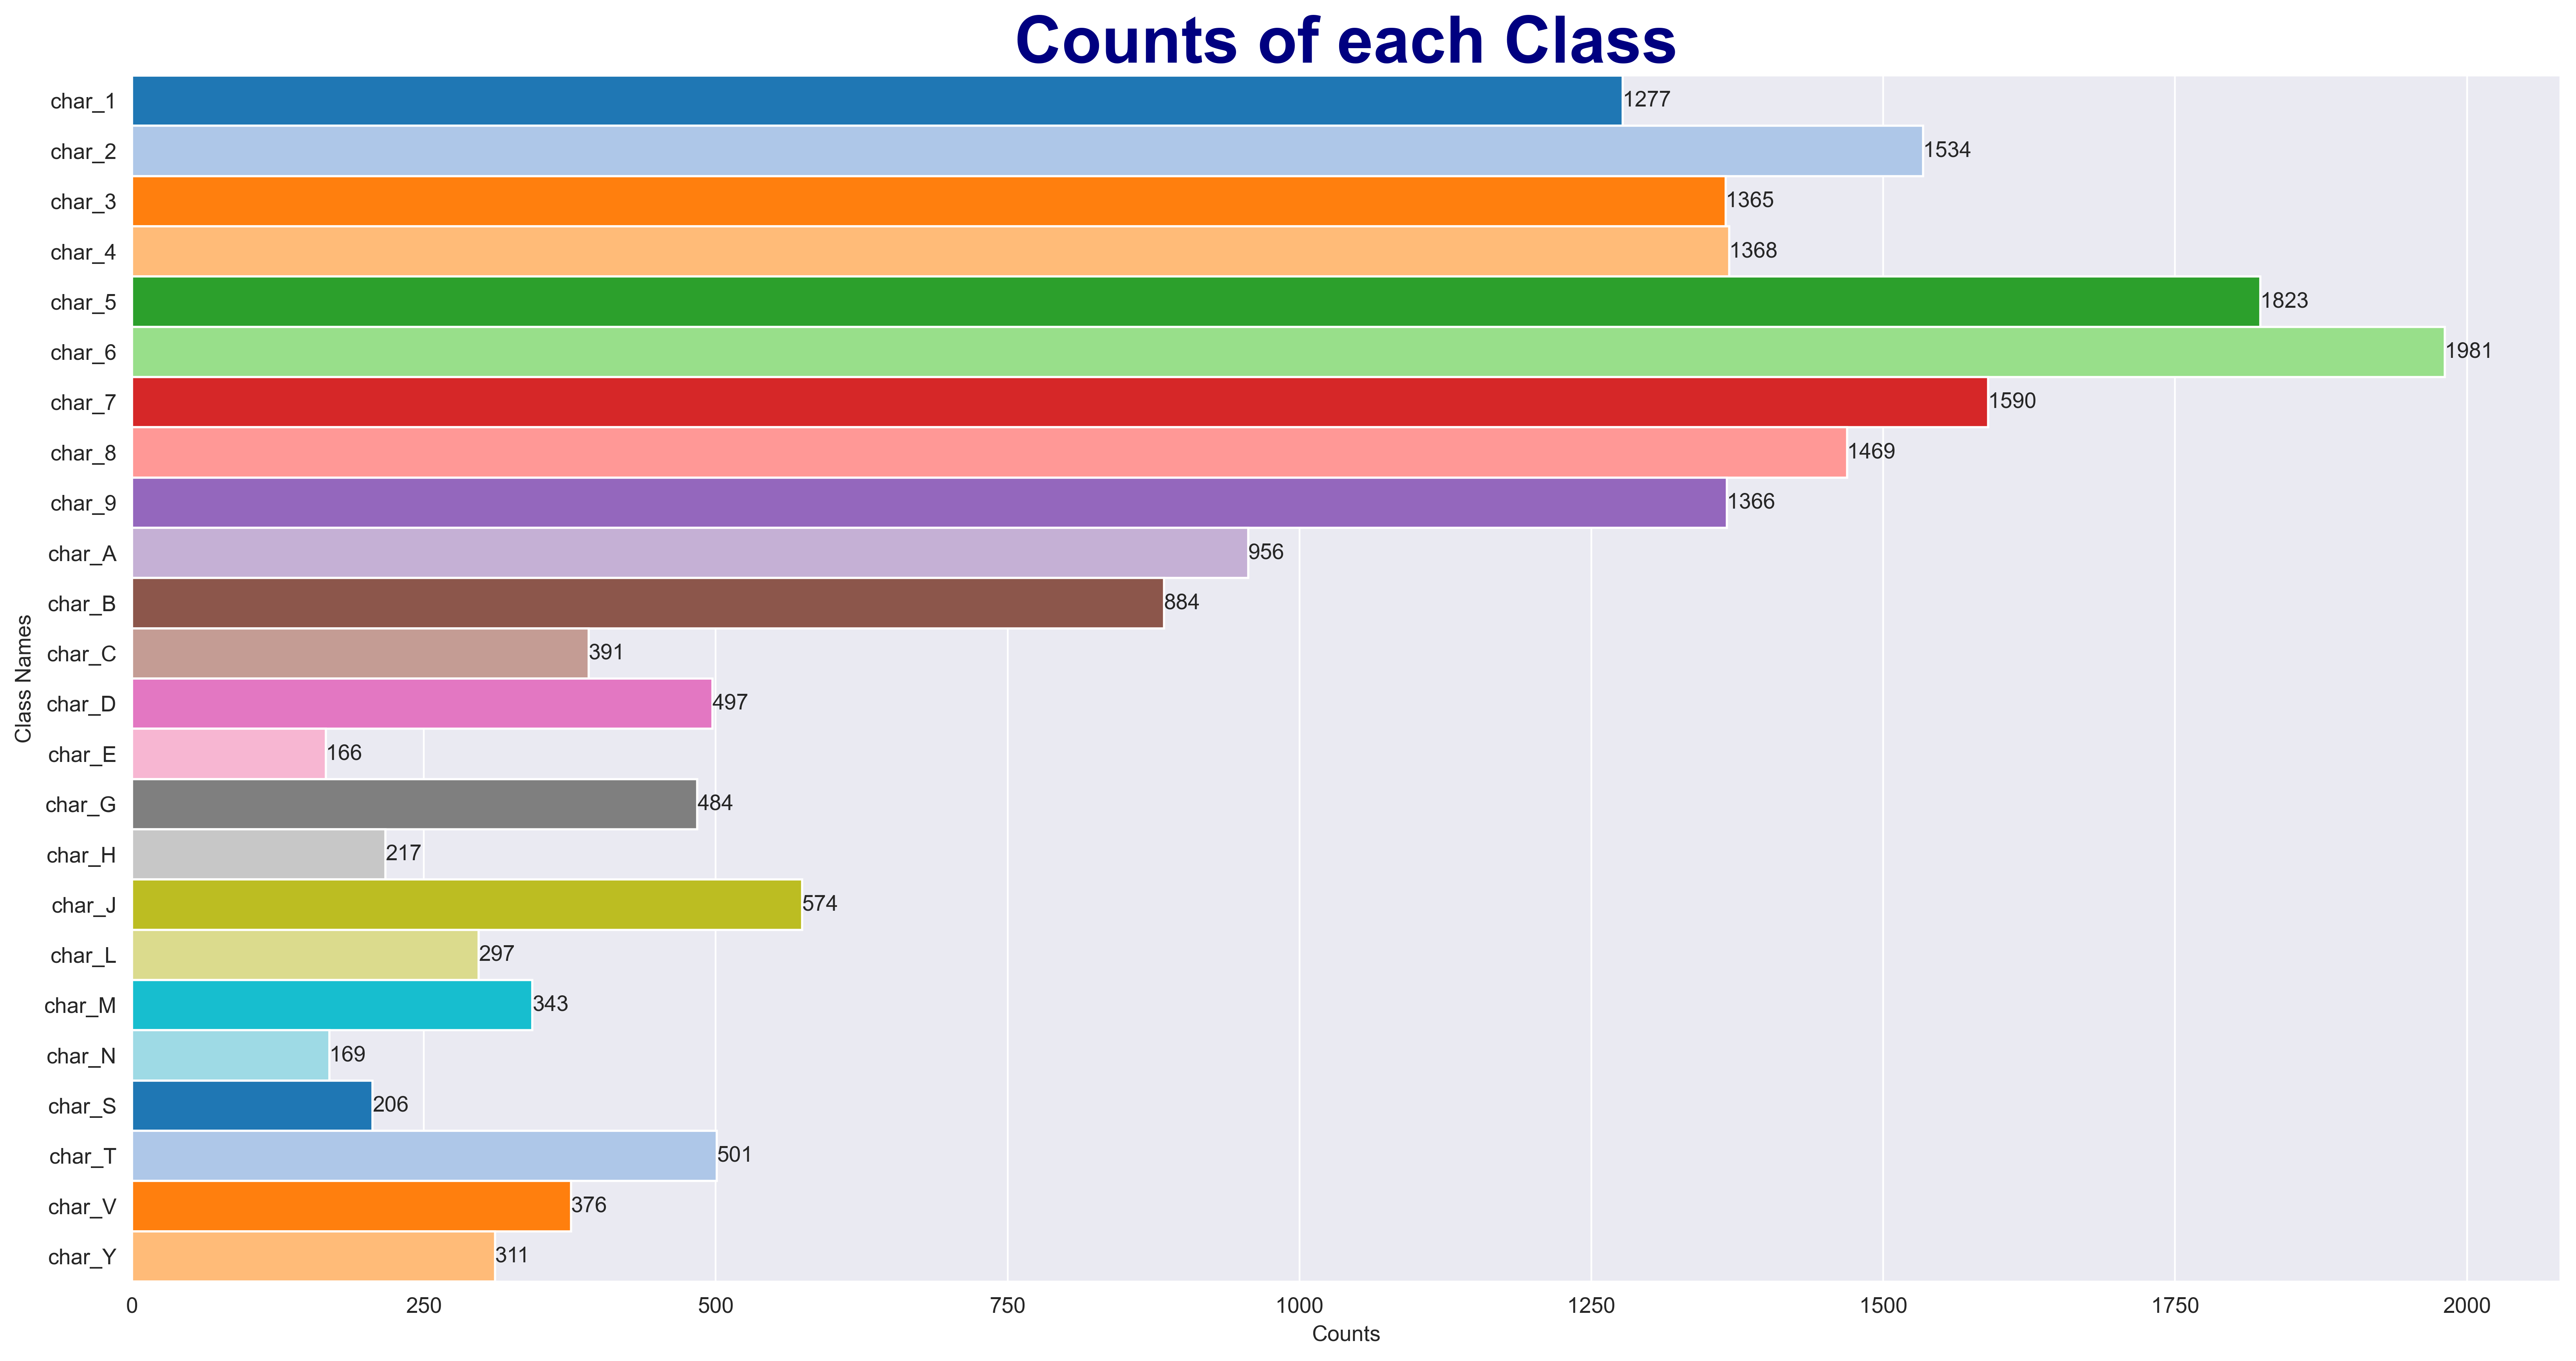

In [11]:
plt.figure(figsize=(20, 10), dpi=400)
ax = sns.barplot(x=counts, hue=alphabet_classes,y=alphabet_classes, palette='tab20', saturation=1.0, width=1.0)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Counts of each Class', fontsize=30, fontweight='bold', c='navy')
plt.ylabel('Class Names')
plt.xlabel('Counts')
plt.show()

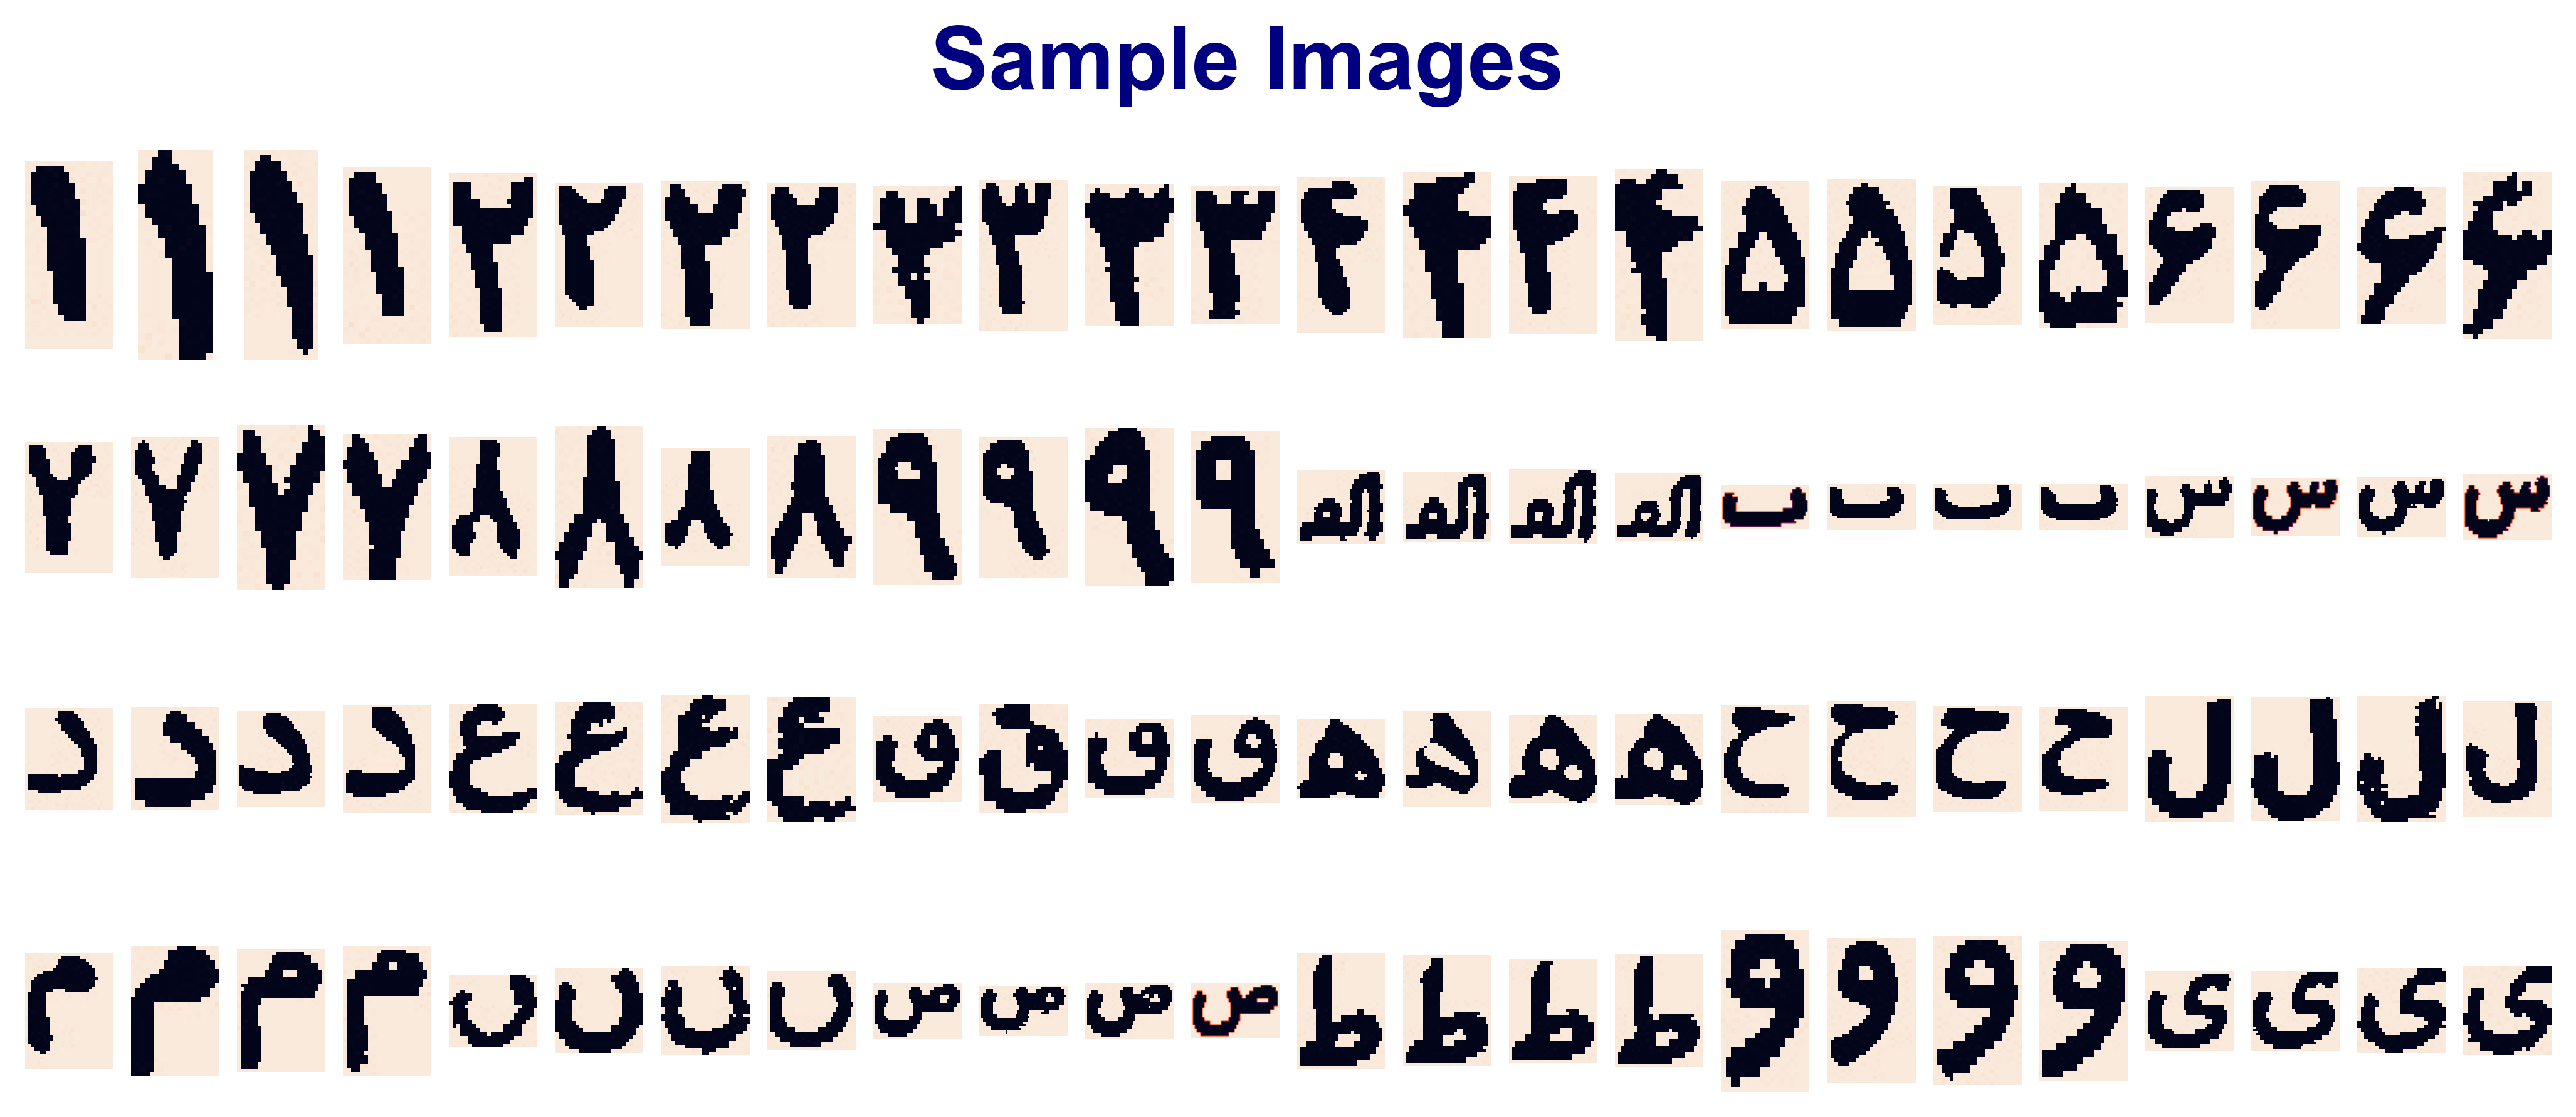

In [12]:
def Plot_Sample_Images() :
    all_images = []
    # alphabet_classes = os.listdir(alphabet_dir)

    for class_name in alphabet_classes :
        class_path = os.path.join(alphabet_dir, class_name)
        class_images = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path)]
        random_images = random.choices(class_images, k=4)
        all_images.extend(random_images)
        
    plt.figure(figsize=(13, 5), dpi=400)
    plt.suptitle('Sample Images', fontsize=25, fontweight='bold', c='navy')
    for i in range(len(all_images)):
        plt.subplot(4, 24, i+1)
        img = plt.imread(all_images[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()

Plot_Sample_Images()

# Image_size

In [13]:
def Fetch_Image_Sizes() :
    '''
    A function to fetch all of images sizes and stored in a Set variable
    '''
    img_sizes = set()

    for class_name in tqdm(alphabet_classes) :
        class_path = os.path.join(alphabet_dir, class_name)
        class_files_path = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path) if file_name.endswith('.jpg')]
        for image_path in class_files_path :
            img = cv2.imread(image_path)
            h, w, c = img.shape
            img_sizes.add((h, w, c))
    return img_sizes

img_sizes = Fetch_Image_Sizes()

100%|██████████| 24/24 [00:02<00:00, 10.57it/s]


In [14]:
if len(img_sizes) == 1 :
    print(f'There is a unique size of {img_sizes[0]} for all images.')
else :
    print(f'Tehre are {len(img_sizes)} different sizes for images.')

Tehre are 1147 different sizes for images.


In [15]:
min(img_sizes), max(img_sizes)

((8, 16, 3), (65, 40, 3))

In [16]:
h_mean = int(np.mean([min(img_sizes)[0], max(img_sizes)[0]]))
w_mean = int(np.mean([min(img_sizes)[1], max(img_sizes)[1]]))

img_size = (h_mean, w_mean)
print(f'Sellected size of images is mean of sizes, is {img_size}')

Sellected size of images is mean of sizes, is (36, 28)


# Split to train, valid, test

In [17]:
# Create a folder to store splited images
splited_alphabet = os.path.join(working_dir, 'splited_alphabet')

if not os.path.exists(splited_alphabet) :
    os.mkdir(splited_alphabet)

In [18]:
# splitfolders.ratio(
#     input=alphabet_dir,
#     output=splited_alphabet,
#     seed=42,
#     ratio=(0.6, 0.2, 0.2)
# )

In [19]:
def Count_images() :
    folders = os.listdir(splited_alphabet)
    print('Number of samples in each folder :')

    for folder in folders :
        count = 0
        folder_path = os.path.join(splited_alphabet, folder)
        for class_name in os.listdir(folder_path) :
            class_path = os.path.join(folder_path, class_name)
            count += len(os.listdir(class_path))
        print(f'{folder} : {count}')

Count_images()

Number of samples in each folder :
test : 4050
train : 27216
val : 4019


In [20]:
train_dir = os.path.join(splited_alphabet, 'train')
valid_dir = os.path.join(splited_alphabet, 'val')
test_dir = os.path.join(splited_alphabet, 'test')

# Augs = Blure, Add-Noise

In [21]:
def Blure_Filter(img, filter_type ="blur", kernel=3):
    '''
    ### Filtering ###
    img: image
    filter_type: {blur: blur, gaussian: gaussian, median: median}
    '''
    if filter_type == "blur":
        return cv2.blur(img,(kernel,kernel))
    
    elif filter_type == "gaussian":
        return cv2.GaussianBlur(img, (kernel, kernel), 0)
    
    elif filter_type == "median":
        return cv2.medianBlur(img, kernel)

In [22]:
def Add_Noise(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss": 
        mean=0
        st=0.5
        gauss = np.random.normal(mean,st,img.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(img,gauss)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return image
    
    elif noise_type == "sp": 
        prob = 0.01
        black = np.array([0, 0, 0], dtype='uint8')
        white = np.array([255, 255, 255], dtype='uint8')

        probs = np.random.random(img.shape[:2])
        img[probs < (prob / 2)] = black
        img[probs > 1 - (prob / 2)] = white
        return img

In [23]:
sample_img = os.path.join(train_dir, 'char_H\\H_45339.jpg')
sample_img

'C:\\envs\\Working\\Iranian_Plates\\splited_alphabet\\train\\char_H\\H_45339.jpg'

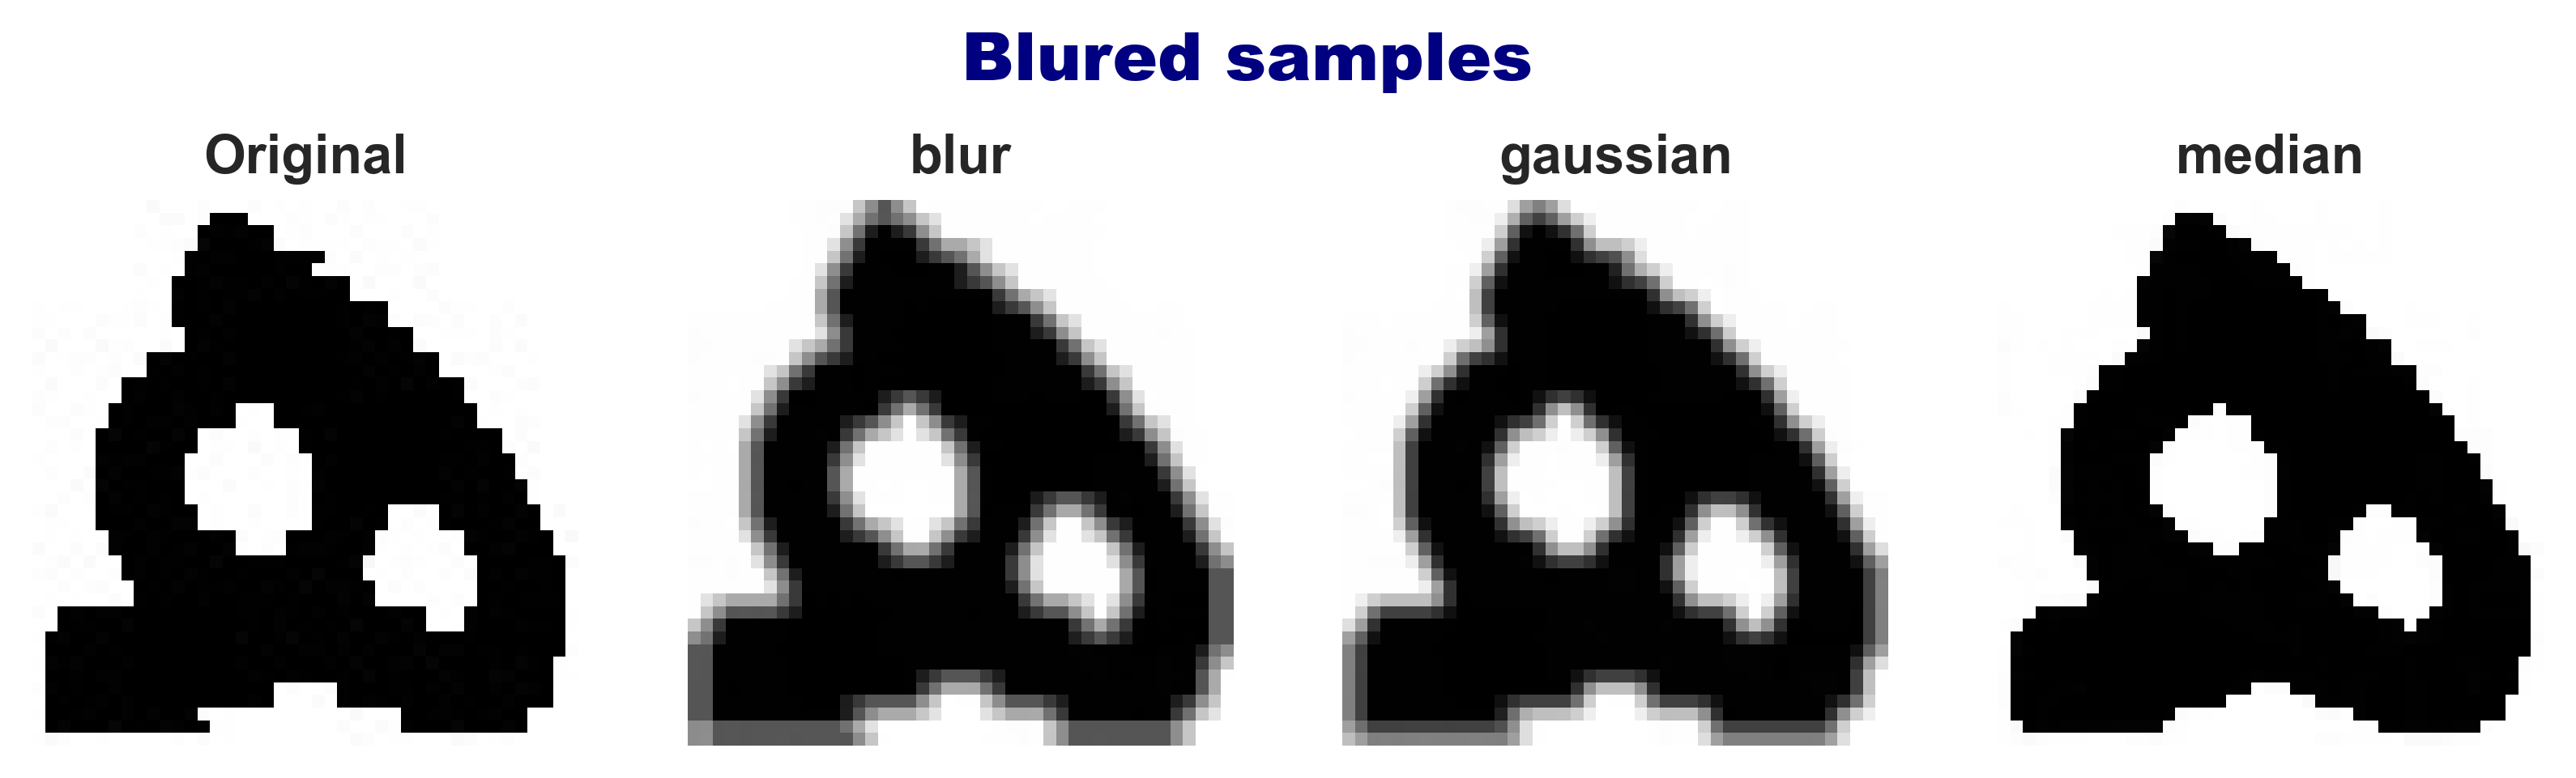

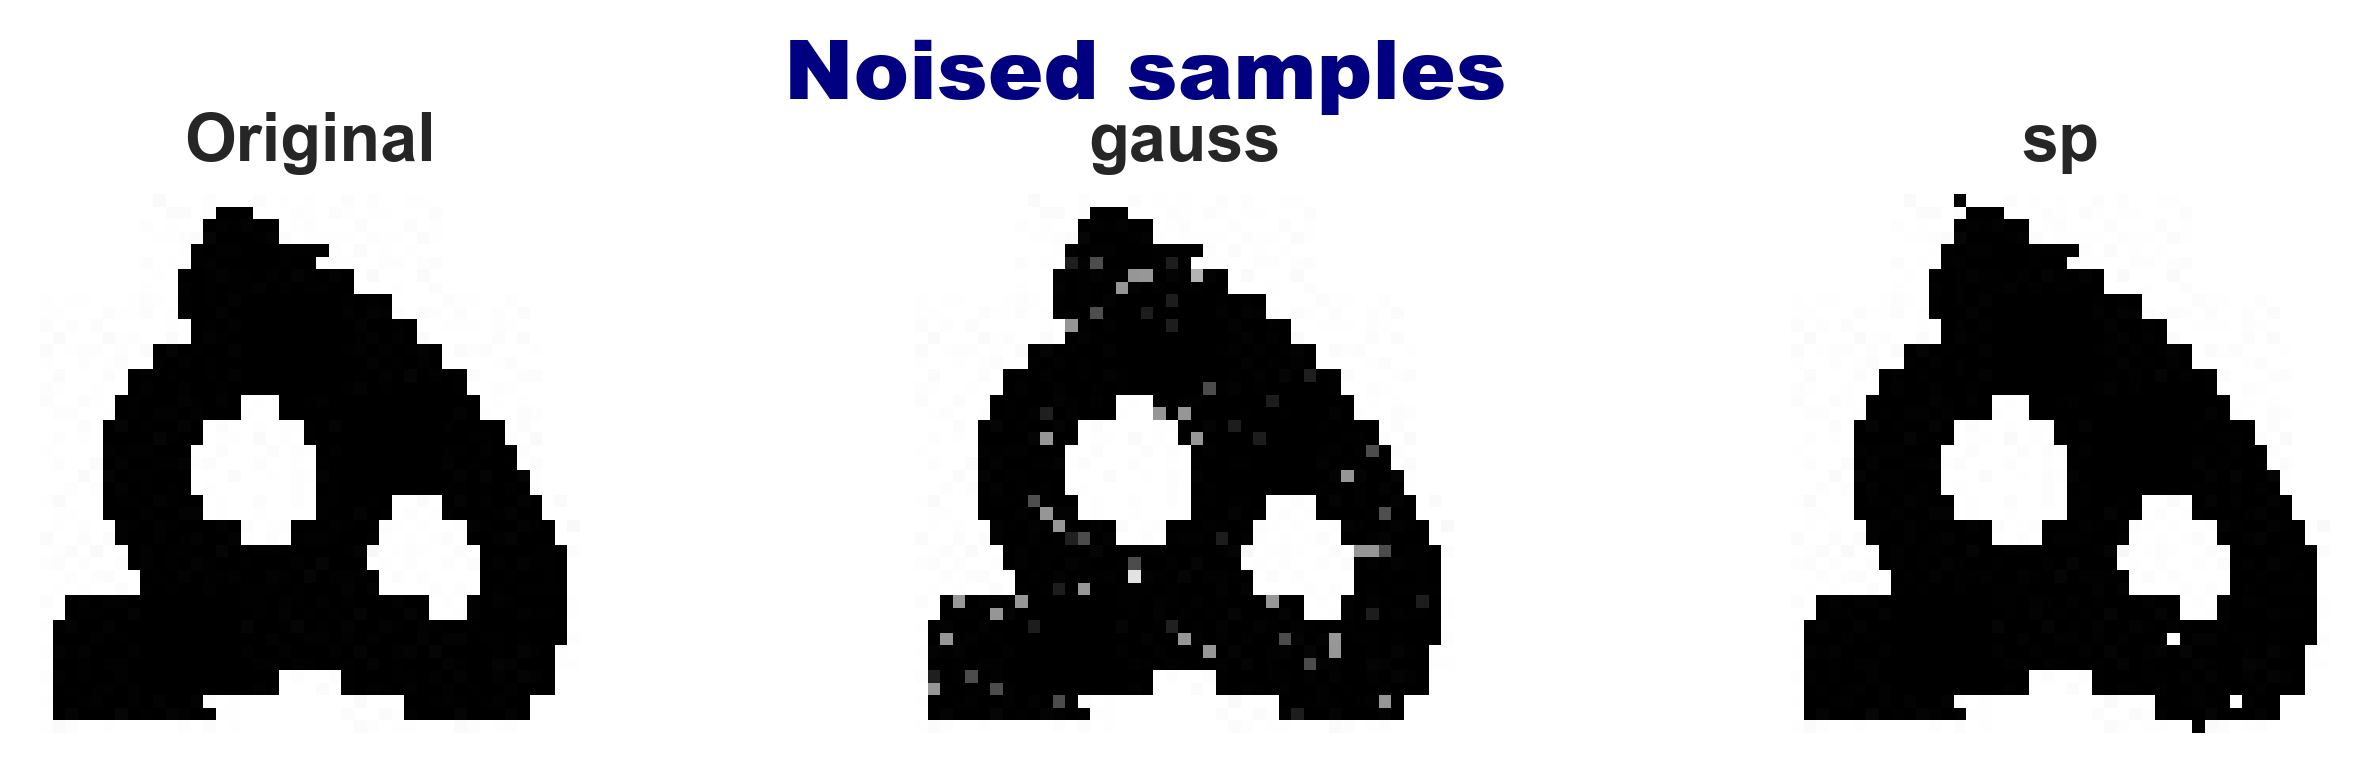

In [24]:
def Plot_AUGS_Samples():
    plt.figure(figsize=(10, 2.25), dpi=400)
    plt.suptitle('Blured samples', fontweight=900, fontsize=15, y=1.1, c='navy')
    # Original image
    plt.subplot(1, 4, 1)
    img = cv2.imread(sample_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original', fontweight=800)
    # Blurs
    # List of filters
    filters = ['blur', 'gaussian', 'median']
    for filter in filters :
        indx = filters.index(filter)
        plt.subplot(1, 4, indx+2)
        filtered_img = Blure_Filter(img, filter_type=filter, kernel=3)
        plt.imshow(filtered_img)
        plt.axis('off')
        plt.title(filter, fontweight=800)

    plt.figure(figsize=(8,1.75), dpi=400)
    plt.suptitle('Noised samples', fontweight=900, fontsize=15, y=1.1, c='navy')
    plt.subplot(1, 3, 1)
    img = cv2.imread(sample_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original', fontweight=800)

    noises = ['gauss', 'sp']
    for noise in noises :
        indx = noises.index(noise)
        plt.subplot(1, 3, indx+2)
        noised_img = Add_Noise(img, noise_type=noise)
        plt.imshow(noised_img, cmap='gray')
        plt.axis('off')
        plt.title(noise, fontweight=800)

Plot_AUGS_Samples()

In [25]:
def Augmentations(img) :
    ''' Apply random choice of augmentation functions on images '''

    returned_augs = dict()

    AUGS = ['Blure', 'Noise']

    # How many of Augs choosen ?
    random_num = random.randint(1, 2)
    random_choice = random.choices(AUGS, k=random_num)
    # To avoid repeatations :
    random_choice = list(set(random_choice))

    for choice in random_choice :
        if choice == 'Blure' :
            filters = ['blur', 'gaussian', 'median']
            kernel = 3
            random_filter = random.choices(filters, k=1)[0]
            blured_img =  Blure_Filter(img, filter_type=random_filter, kernel=kernel)
            new_name = '_blured'
            returned_augs[new_name] = blured_img


        elif choice == 'Noise' :
            noises = ['gauss', 'sp']
            random_noise = random.choices(noises, k=1)[0]
            noised_img = Add_Noise(img, noise_type=random_noise)
            new_name = '_noised'
            returned_augs[new_name] = noised_img
            
    return returned_augs

## apply aug to train_folder

In [26]:
def Count_Train_Images():
    '''
    A function to counts number of images in train folder
    '''
    num_images = 0

    for class_name in os.listdir(train_dir) :
        class_path = os.path.join(train_dir, class_name)
        num_images += len(os.listdir(class_path))
    
    return num_images

num_images_before_augs = Count_Train_Images()
print(f'Number of Train-images before Augmentations : {num_images_before_augs}')

Number of Train-images before Augmentations : 27216


In [27]:
# def Apply_Augmentations():
#     for class_name in os.listdir(train_dir) :
#         class_path = os.path.join(train_dir, class_name)
#         for file_name in tqdm(os.listdir(class_path)) :
#             img_path = os.path.join(class_path, file_name)
#             img = cv2.imread(img_path)
#             returned = Augmentations(img)

#             for exported_name, exported_image in returned.items() :
#                 # 1_left.jpg ---TO---> 1_lef_blured.jpg
#                 new_name = file_name.split('.')[0] + exported_name + '.' + file_name.split('.')[-1]
#                 new_path = os.path.join(class_path, new_name)
            
#                 # Save new image
#                 cv2.imwrite(new_path, exported_image) 

# Apply_Augmentations()

In [28]:
num_images_after_augs = Count_Train_Images()
print(f'Number of Train-images before Augmentations : {num_images_after_augs}')

Number of Train-images before Augmentations : 27216


In [29]:
print(f'{num_images_after_augs - num_images_before_augs} images added by Data-Augmentations')

0 images added by Data-Augmentations


# DataSets and DataLoaders

In [30]:
batch_size = 64

In [31]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

In [32]:
############################| Train |############################
# Create Dataset from Images
train_ds = ImageFolder(root=train_dir, transform=transform)

# Create DataLoader from defined dataset
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

print('Train Dataset\n')
print(train_ds)
print()
print('Train DataLoader\n')
print(train_loader)
print('_'*100)
############################| Validation |############################
# Create Dataset from Images
valid_ds = ImageFolder(root=valid_dir, transform=transform)

# Create DataLoader from defined dataset
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

print('Validation Dataset\n')
print(valid_ds)
print()
print('Validation DataLoader\n')
print(valid_loader)
print('_'*100)
############################| Test |############################
# Create Dataset from Images
test_ds = ImageFolder(root=test_dir, transform=transform)

# Create DataLoader from defined dataset
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

print('Test Dataset\n')
print(test_ds)
print()
print('Test DataLoader\n')
print(test_loader)
print('_'*100)

Train Dataset

Dataset ImageFolder
    Number of datapoints: 27216
    Root location: C:\envs\Working\Iranian_Plates\splited_alphabet\train
    StandardTransform
Transform: Compose(
               Resize(size=(36, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Train DataLoader

____________________________________________________________________________________________________
Validation Dataset

Dataset ImageFolder
    Number of datapoints: 4019
    Root location: C:\envs\Working\Iranian_Plates\splited_alphabet\val
    StandardTransform
Transform: Compose(
               Resize(size=(36, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Validation DataLoader

____________________________________________________________________________________________________
Test Dataset

Dataset ImageFolder
    Number of datapoints: 4050
    Root location: C:\envs\Working\Iranian_Plates\splited_alph

In [33]:
# print shape of dataset for each set
for key, value in {'Train': train_loader, "Validation": valid_loader, 'Test': test_loader}.items():
    for X, y in value:
        print(colored(f'{key}:', 'white','on_green', attrs=['bold']))
        print(f"Shape of images [Batch_size, Channels, Height, Width]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        print('-'*45)
        break

Train:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 36, 28])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------
Validation:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 36, 28])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------
Test:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 36, 28])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------


# Space Freeup

In [34]:
del [alphabet_base, alphabet_dir, ax, container, img_sizes, h_mean, w_mean, splited_alphabet, train_dir, valid_dir, test_dir, sample_img, num_images_before_augs, num_images_after_augs, transform]

In [35]:
gc.collect()

200885

In [36]:
torch.cuda.empty_cache()

# Model

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda' :
    print('GPU is available.')
else :
    print('You are using CPU !')

GPU is available.


In [38]:
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

In [39]:
# model = googlenet(weights=GoogLeNet_Weights)
model = efficientnet_b5(weights=EfficientNet_B5_Weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [40]:
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=512, out_features=64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=64, out_features=len(alphabet_classes))
)

In [41]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [42]:
def DeltaTime(dt) :
    '''A Function to apply strftime manualy on delta.datetime class'''
    h = dt.seconds // 3600
    dh = dt.seconds % 3600

    m = dh // 60
    s = dh % 60

    if h<10 : h='0'+str(h)
    else : h = str(h)

    if m<10 : m='0'+str(m)
    else : m = str(m)

    if s<10 : s='0'+str(s)
    else : s = str(s)

    return( h + ':' + m + ':' + s)

In [43]:
def Beauty_epoch(epoch) :
    ''' Return epochs in 2 digits - like (01 or 08) '''
    if epoch<10 :
        return '0' + str(epoch)
    else :
        return str(epoch)

In [44]:
def Save_Best_Weight(val_loss) :
    best_loss_save = 0
    if val_loss > best_loss_save :
        best_loss_save = val_loss
        torch.save(model, 'Best_weight.pt')


# def Reduce_Learning_Rate(Learning_Rate, val_losses) :
#     if len(val_losses) > 4 :
#         temp_list = val_losses[-4:]
#         if (temp_list[0] < temp_list[1]) and (temp_list[0] < temp_list[2]) and (temp_list[0] < temp_list[3]) :
#                 Learning_Rate = Learning_Rate/2
#     return Learning_Rate

In [45]:
num_epochs = 30

In [47]:
# Create Loss_function and Optimizer
Learning_Rate = 0.01

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=Learning_Rate)

# Some variables to store loss and accuracy to plot them
train_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
valid_losses = np.zeros(num_epochs)
valid_accs = np.zeros(num_epochs)

print(colored('Training Starts ... ', 'blue', 'on_white', attrs=['bold']))
for epoch in range(num_epochs) :

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Learning_Rate)
    
    # Set the mode to TRAIN
    model.train()

    # Current time to calculate duration of epoch
    t0 = datetime.now()

    # Some variables to store data
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    n_correct = 0
    n_total = 0

            ###############
            #### Train ####
            ###############

    # Read Images and Labels from TrainLoader
    for images, labels in train_loader :
        # Move Data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Reshape labels to [Batch-Size, 1]
        # labels = torch.reshape(labels, (-1, 1))

        # Zero Grad Optimizer
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Train Loss
        train_loss.append(loss.item())

        # Train Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]

    train_losses[epoch] = np.mean(train_loss)
    train_accs[epoch] = n_correct / n_total

            ####################
            #### Validation ####
            ####################

    n_correct = 0
    n_total = 0

    # Read Images and Labels from ValidLoader
    for images, labels in valid_loader :
        # Move Data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Reshape labels to [Batch-Size, 1]
        # labels = torch.reshape(labels, (-1, 1))

        # Forward pass
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Validation Loss
        valid_loss.append(loss.item())

        # val Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]
    
    valid_losses[epoch] = np.mean(valid_loss)
    valid_accs[epoch] = n_correct / n_total

    Save_Best_Weight(valid_losses[epoch])

    ############################### Duration ###############################

    dt = datetime.now() - t0

    ############################### BEAUTIFULL OUTPUT ###############################
    EPOCH =  colored(f' Epoch [{Beauty_epoch(epoch+1)}/{num_epochs}] ', 'black', 'on_white', attrs=['bold'])
    TRAIN_LOSS = colored(f' Train Loss:{train_losses[epoch]:.4f} ', 'white', 'on_green', attrs=['bold'])
    TRAIN_ACC = colored(f' Train Acc:{train_accs[epoch]:.4f} ', 'white', 'on_blue', attrs=['bold'])
    VAL_LOSS = colored(f' Val Loss:{valid_losses[epoch]:.4f} ', 'white', 'on_green', attrs=['bold'])
    VAL_ACC = colored(f' Val Acc:{valid_accs[epoch]:.4f} ', 'white', 'on_blue', attrs=['bold'])
    DURATION = colored(f' Duration : {DeltaTime(dt)} ', 'white', 'on_dark_grey', attrs=['bold'])
    LR = colored(f' lr = {Learning_Rate} ', 'black',  'on_cyan', attrs=['bold'])

    ###################################### CallBacks ######################################

    # Learning_Rate = Reduce_Learning_Rate(Learning_Rate=Learning_Rate, val_losses=valid_losses)
    if epoch > 4 :
        temp_valid_losses = valid_losses[: epoch]
        if temp_valid_losses[-1] > temp_valid_losses[-2] > temp_valid_losses[-3] :
            Learning_Rate /= 10


    # Print the result of  each epochs
    print(f'{EPOCH} -> {TRAIN_LOSS}{TRAIN_ACC} {VAL_LOSS}{VAL_ACC} {DURATION} {LR}')


print(colored('Training Finished ...', 'blue', 'on_white', attrs=['bold']))

Training Starts ... 
 Epoch [01/30]  ->  Train Loss:0.0714  Train Acc:0.9905   Val Loss:0.1891  Val Acc:0.9734   Duration : 00:01:35   lr = 0.01 
 Epoch [02/30]  ->  Train Loss:0.0581  Train Acc:0.9931   Val Loss:0.0676  Val Acc:0.9923   Duration : 00:01:36   lr = 0.01 


In [ ]:
plt.figure(figsize=(12, 3), dpi=400)
plt.subplot(1, 2, 1)
sns.lineplot(train_accs, label='Train Accuracy')
sns.lineplot(valid_accs, label='Valid Accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(train_losses, label='Train Loss')
sns.lineplot(valid_losses, label='Validation Loss')
plt.title('Loss')

plt.show()

In [48]:
best_model = torch.load('Best_weight.pt')

In [ ]:
with torch.no_grad() :
    best_model.eval()
    t0 = datetime.now()
    test_loss = []
    val_loss = []
    n_correct = 0
    n_total = 0

    for images, labels in test_loader :
        # Move input data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        y_pred = best_model(images)
        loss = criterion(y_pred, labels)

        # Train Loss
        test_loss.append(loss.item())

        # Train Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]

    test_loss = np.mean(train_loss)
    train_acc = n_correct / n_total
    dt = datetime.now() - t0
    print(colored(f'Loss:{test_loss:.4f}\nAccuracy:{train_acc:.4f}\nDuration:{dt}', 'green', attrs=['bold']))

In [ ]:
# Create a label_map to show True and Predicted labels in below plot
alphabet_classes.sort()

labels_map = {}

for index, label in enumerate(alphabet_classes) :
    labels_map[index] = label

labels_map

In [ ]:
# Move model to CPU
cpu_model = best_model.cpu()

# Get 1 batch of test_loader
for imgs, labels in test_loader :
    break

# Plot 1 batch of test_loader images with True and Predicted label
plt.subplots(4, 8, figsize=(16, 12))
plt.suptitle('Rice images in 1 Batch', fontsize=25, fontweight='bold')
for i in range(32) :
    ax = plt.subplot(4, 8, i+1)
    img = torch.permute(imgs[i], (1, 2, 0))
    plt.imshow(img)
    label = labels_map[int(labels[i])]
    img = img[i].unsqueeze(0)
    img = imgs[i].unsqueeze(0)
    out = cpu_model(img)
    predict = labels_map[int(out.argmax())]
    plt.title(f'True :{label}\nPredict :{predict}')
    plt.axis('off')

plt.show()

In [52]:
# Get out 2 list include y_true and y_pred for use in confusion_matrix
model = best_model.to(device)

y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.numpy()
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()
    
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

In [53]:
from sklearn.metrics import confusion_matrix, classification_report 

In [ ]:
classes = labels_map.values()

print(classification_report(y_true, y_pred))

def plot_confusion_matrix(y_test, y_prediction):
    '''Plotting Confusion Matrix'''
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.figure(figsize=(15, 10))
    ax = sns.heatmap(cm, annot=True, fmt='', cmap="Blues")
    ax.set_xlabel('Prediced labels', fontsize=20)
    ax.set_ylabel('True labels', fontsize=20)
    ax.set_title('Confusion Matrix', fontsize=25)
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes) 
    plt.xticks(rotation=-60)
    plt.yticks(rotation=0)
    plt.show()


plot_confusion_matrix(y_true, y_pred)

_____________________________________________________________________________________________________________________________________________________________________

# Phase 02  - Plate Detection with Ultralytitcs

_____________________________________________________________________________________________________________________________________________________________________

# Data Loading

In [ ]:
base_dir = 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb'

# Path of yaml file
yaml_path = os.path.join(base_dir, 'data.yaml')

# Path of Train directory
train_dir = os.path.join(base_dir, 'train')
train_images = os.path.join(train_dir, 'images')
train_labels = os.path.join(train_dir, 'labels')

# Path of Validation directory
valid_dir = os.path.join(base_dir, 'valid')
valid_images = os.path.join(valid_dir, 'images')

# Path of Test directory
test_dir = os.path.join(base_dir, 'test')
test_images = os.path.join(test_dir, 'images')

In [ ]:
print(colored(f' Number of Train Images : {len(os.listdir(train_images))} ', 'blue', 'on_white', attrs=['bold']))
print(colored(f' Number of Validation Images : {len(os.listdir(valid_images))}', 'blue', 'on_white',  attrs=['bold']))
print(colored(f' Number of Test Images : {len(os.listdir(test_images))} ', 'blue', 'on_white',  attrs=['bold']))
print('_'*70)
print(colored(f' Number of All Images : {len(os.listdir(train_images)) + len(os.listdir(valid_images)) + len(os.listdir(test_images))} ', 'green', 'on_white',  attrs=['bold']))

# Image Sizes

In [ ]:
def Image_Size(train_images) :
    img_sizes = set()

    for img_name in tqdm(os.listdir(train_images)) :
        img_path = os.path.join(train_images, img_name)
        img = cv2.imread(img_path)
        h, w, c = img.shape
        img_sizes.add((h, w))

    return img_sizes

img_sizes = Image_Size(train_images)

if len(img_sizes) == 1 :
    print(f'All the images have size of {img_sizes}')
else :
    print(f'There are {len(img_sizes)} different image sizes !')


In [ ]:
img_size = (640, 640)
H = img_size[0]
W = img_size[1]

# Plot Random Images With BBOXs

In [ ]:
def TXT_To_BBOX(lbl_path) :
    bbox = open(lbl_path, 'r')
    bbox = bbox.read()
    bbox = bbox.split(' ')[1:]

    p1 = [int(float(bbox[0])*H), int(float(bbox[1])*W)]
    p2 = [int(float(bbox[2])*H), int(float(bbox[3])*W)]
    p3 = [int(float(bbox[4])*H), int(float(bbox[5])*W)]
    p4 = [int(float(bbox[6])*H), int(float(bbox[7])*W)]

    pts = np.array([p1, p2, p3, p4], np.int32)
    pts = pts.reshape((-1, 1, 2))
    return pts

In [ ]:
def JPG_Name_To_TXT(img_name) :
    name = img_name.split('.')[:-1]
    name = '.'.join(name)
    txt_name = name + '.txt'
    return txt_name

In [ ]:
def Plot_Random_Images() :
    random_images = random.choices(os.listdir(train_images), k=12)
    i = 1
    plt.figure(figsize=(20, 7))
    for img_name in random_images :
        plt.subplot(2, 6, i)
        # Image
        img_path = os.path.join(train_images, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # BBox
        txt_name = JPG_Name_To_TXT(img_name)
        lbl_path = os.path.join(train_labels, txt_name)
        pts = TXT_To_BBOX(lbl_path)
        cv2.polylines(img, [pts], True, (0, 255, 0), 5, cv2.LINE_AA)

        plt.imshow(img)
        plt.axis('off')
        i += 1
Plot_Random_Images()

# Model

In [ ]:
yolo_model = YOLO('yolov8n.yaml').load('yolov8n.pt')

result = yolo_model.train(data=yaml_path, epochs=20, amp=False)

In [ ]:
# Location of stored result
result_path = result.save_dir

In [ ]:
# List of some metrics
metrics = ['results.png','confusion_matrix.png', 'P_curve.png', 'PR_curve.png']

plt.figure(figsize=(15, 12))
i = 1

for image_name in metrics:
    image_path = os.path.join(result_path, image_name)
    image = cv2.imread(image_path)
    
    plt.subplot(2, 2, i)
    
    plt.imshow(image)
    plt.title(image_name)
    i += 1

plt.show()

In [ ]:
# Read csv of result
df = pd.read_csv(os.path.join(result_path, 'results.csv'))
df.tail(5)

In [ ]:
# Strip columns
df.columns = df.columns.str.strip()
df.columns

In [ ]:
# Define X, y to plot
X = df.epoch
cols = df.columns[1:]

plt.figure(figsize=(15, 25))

for it in range(len(cols)) :
    plt.subplot(7, 2, it+1)
    ax = sns.lineplot(data=df, x=X, y=cols[it])
    ax.set_title(cols[it])
plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Load model with best weights
best_model_path = os.path.join(result_path, 'weights/best.pt')

best_model = YOLO(best_model_path)

In [ ]:
# Evaluating the model
result_test = best_model.val()

In [ ]:
result_test

In [ ]:
keys = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

for key in keys :
    print(colored(f'{key} : {result_test.results_dict[key]}', 'green', attrs=['bold']))

In [ ]:
images = os.listdir(test_images)
num_samples = 12

random_images = random.choices(images, k=num_samples)

images = []
for image in random_images :
    image_path = os.path.join(test_images, image)
    images.append(image_path)

images

In [ ]:
for image in images :
    result = best_model.predict([image], save=True, conf=0.5, iou=0.7)

In [ ]:
# Location of saved predicted images
result_path = result[0].save_dir
print(result_path)

In [ ]:
# Show images
i = 1
plt.figure(figsize=(12, 10), dpi=200)
for image in os.listdir(result_path) :
    image_path = os.path.join(result_path, image)
    plt.subplot(3, 4, i)
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.subplots_adjust(top=0.75)
    i+=1

In [ ]:
result[0].boxes.xyxy.tolist()

_____________________________________________________________________________

# Phase 3 - Combination Of Phase 1 and Phase 2

In [ ]:
Original_img_path = os.path.join(test_images, '468_png.rf.1cf6ba0291eb541165c7da153e39e648.jpg')

result = best_model.predict([Original_img_path], save=True, conf=0.5, iou=0.7)


0: 640x640 1 Plates, 147.4ms
Speed: 6.9ms preprocess, 147.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict2


In [ ]:
os.listdir(result[0].save_dir)[-1]

'468_png.rf.1cf6ba0291eb541165c7da153e39e648.jpg'

(-0.5, 639.5, 639.5, -0.5)

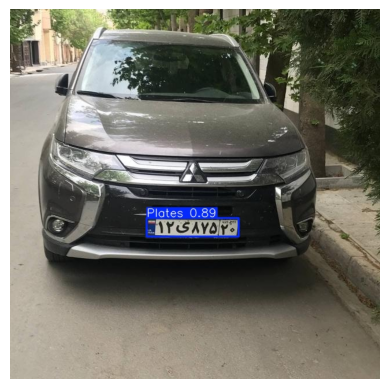

In [ ]:
img_path = os.path.join(result[0].save_dir, os.listdir(result[0].save_dir)[-1])

plt.imshow(plt.imread(img_path))
plt.axis('off')

In [ ]:
bbox = result[0].boxes.xyxy.tolist()
bbox = bbox[0]
bbox

[236.14883422851562, 361.8581848144531, 395.2672424316406, 393.5346374511719]

In [ ]:
x1 = int(bbox[0])
y1 = int(bbox[1])
x2 = int(bbox[2])
y2 = int(bbox[3])

In [ ]:
X = x2 - x1
Y = y2 - y1

In [ ]:
img = cv2.imread(img_path)
img2 = img[x1:x2, y1:y2]

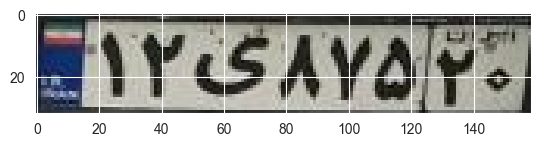

In [ ]:
img = cv2.imread(Original_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[y1:y2, x1:x2]
plt.imshow(img)
# plt.axis('off')

In [ ]:
img.shape

(32, 159, 3)

(30, 150, 3)


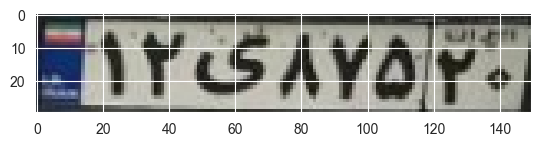

In [ ]:
img2 = cv2.resize(img, (150, 30))
print(img2.shape)

plt.imshow(img2)
plt.show()

(-0.5, 16.5, 21.5, -0.5)

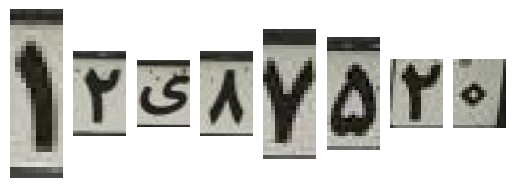

In [ ]:
p1 = img[:, 20:30]
p2 = img[:, 30:50]
p3 = img[:, 50:75]
p4 = img[:, 75:95]
p5 = img[:, 95:108]
p6 = img[:, 108:123]
p7 = img[10:, 125:142]
p8 = img[10:, 142:]


plt.subplot(1, 8, 1)
plt.imshow(p1)
plt.axis('off')

plt.subplot(1, 8, 2)
plt.imshow(p2)
plt.axis('off')

plt.subplot(1, 8, 3)
plt.imshow(p3)
plt.axis('off')

plt.subplot(1, 8, 4)
plt.imshow(p4)
plt.axis('off')

plt.subplot(1, 8, 5)
plt.imshow(p5)
plt.axis('off')

plt.subplot(1, 8, 6)
plt.imshow(p6)
plt.axis('off')

plt.subplot(1, 8, 7)
plt.imshow(p7)
plt.axis('off')

plt.subplot(1, 8, 8)
plt.imshow(p8)
plt.axis('off')


In [ ]:
model = torch.load('Best_weight.pt')
cpu_model = best_model.cpu()

In [ ]:
P = cv2.resize(p1, (640, 640))
print(P.shape)
P = P.astype(np.float32)
P = torch.tensor(P)
print(P.shape)
P = torch.permute(P, (2, 0, 1))
print(P.shape)
P = np.reshape(P, (1, 3, 640, 640))
print(P.shape)

(640, 640, 3)
torch.Size([640, 640, 3])
torch.Size([3, 640, 640])
torch.Size([1, 3, 640, 640])


In [ ]:
P = P/255.0

In [ ]:
out = cpu_model(P)
out

RuntimeError: Inference tensors do not track version counter.

In [ ]:
# img_sizes, base_dir, 